[-2378.089705310731, -1829.0304760260997, -1987.013385076253]


<Figure size 432x288 with 0 Axes>

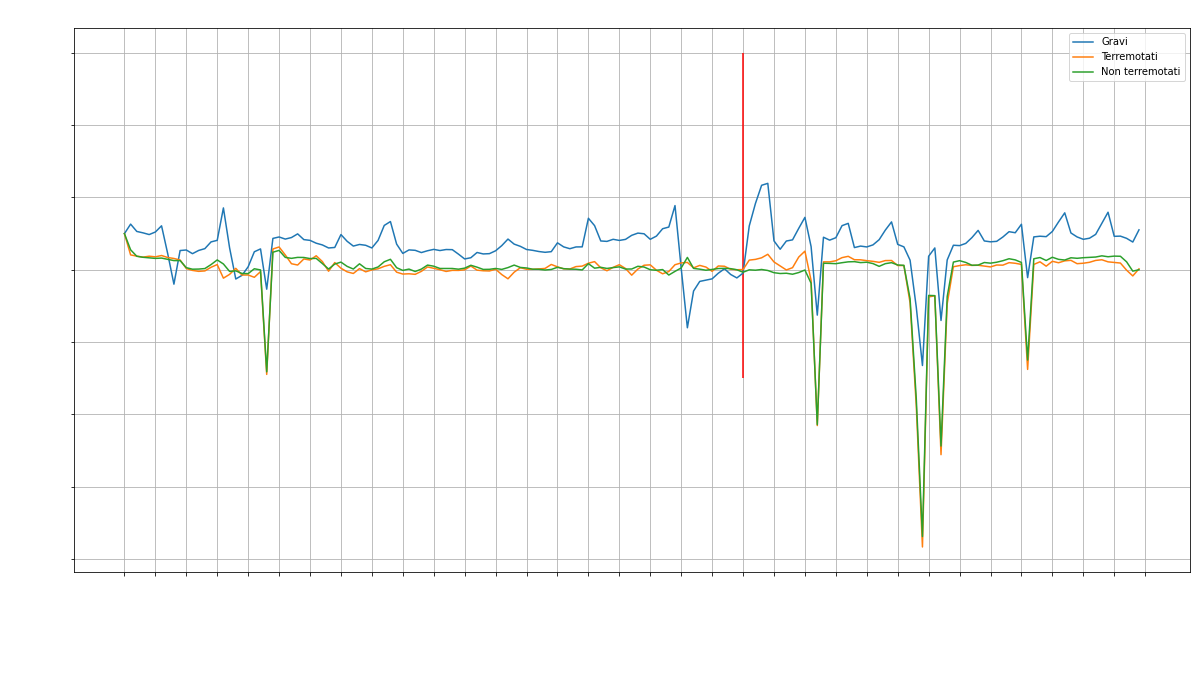

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import math
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import numpy as np
import datetime
from os import listdir
from os.path import isfile, join

from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages

percorso = 'D:/Università/Tirocinio/Analisi Dati/Studio Dati/'
cartella = 'risultati_terremoto/'
# percorso = 'D:/Tirocinio/programmi/Studio Dati/'

coms = pd.Series(pd.read_csv('D:/Università/Tirocinio/Analisi Dati/Grezzo Niki/sezione2comuneDEF.csv').comune.unique(),
                 name='Comune')
# coms = pd.Series(pd.read_csv('D:/Tirocinio/programmi/Grezzo Niki/sezione2comuneDEF.csv').comune.unique(), name= 'Comune')
crateri = pd.read_csv('D:/Università/Tirocinio/Analisi Dati/Studio Dati/crateriCentroIT.csv', sep=';').merge(coms,
                                                                                                             how='outer').drop(
    columns='Provincia')
# crateri = pd.read_csv('D:/Tirocinio/programmi/Studio Dati/crateriCentroIT.csv', sep=';').merge(coms, how='outer').drop(columns='Provincia')
crateri['Cratere Centro Italia 2016'].fillna('0', inplace=True)
onlyfiles = [f for f in listdir(f'{percorso}/risultati_terremoto/') if
             isfile(join(f'{percorso}/risultati_terremoto/', f))]
inizio1 = '20150515'
fine1 = '20151231'
inizio2 = '20160515'
fine2 = '20161231'


def periodi(inizio1, fine1, inizio2, fine2):
    inizio = [pd.to_datetime(inizio1, format='%Y%m%d'), pd.to_datetime(inizio2, format='%Y%m%d')]
    # Mancano 4 ore nel giorno 2016-08-16
    fine = [pd.to_datetime(fine1, format='%Y%m%d'), pd.to_datetime(fine2, format='%Y%m%d')]
    #comune = 'Macerata'
    for years in range(2):
        ini = inizio[years]
        fin = fine[years]
        files = []
        for i in onlyfiles:
            data = pd.to_datetime(i.split('_')[1])
            if data >= ini and data <= fin:
                files.append(i)

        gg = pd.read_csv(f'{percorso}{cartella}{files[0]}', header=None)
        gg = gg.drop_duplicates(keep='last', ignore_index=True)
        db = gg.groupby(0).mean().reset_index()
        db.rename(columns={0: 'Comune', 1: f'{gg.iloc[0, 2][6:8]}_{gg.iloc[0, 2][4:6]}_{gg.iloc[0, 2][0:4]}'},
                  inplace=True)
        for i in range(1, len(files)):
            gg = pd.read_csv(f'{percorso}{cartella}{files[i]}', header=None)
            gg = gg.drop_duplicates(keep='first', ignore_index=True)
            ciclo = gg.groupby(0).mean().reset_index()
            ciclo.rename(columns={0: 'Comune', 1: f'{gg.iloc[0, 2][6:8]}_{gg.iloc[0, 2][4:6]}_{gg.iloc[0, 2][0:4]}'},
                         inplace=True)

            db = pd.merge(db, ciclo)
        df = pd.merge(db, crateri)
        cols = df.columns.tolist()
        cols = cols[:1] + cols[-1:] + cols[1:-1]
        checked = cols[:3]
        next = int(cols[2][:2])
        for i in range(3, len(cols)):
            now = next
            next = int(cols[i][:2])
            if next == now + 1:
                checked.append(cols[i])
            elif now in [28, 30, 31] and next == 1:
                checked.append(cols[i])
            else:
                print(f'now = {cols[i - 1]} -->{now}\n next = {cols[i]}--> {next}')
                break
        df = df[checked]
        if years == 0:
            se = df
        else:
            di = df
    return [se, di]


#media settimanale
# ms = qu.transpose()
# comu = ms.iloc[0, :]
# ms.drop(index=['Comune', 'Cratere Centro Italia 2016'], inplace=True)
# first_day = ms.index[0][:5]
# ms.set_index(np.arange(ms.shape[0])//7,drop = True,inplace= True)
# ms = ms.iloc[:,:].astype(float)
# ms = ms.groupby(ms.index).mean().transpose()
#ms.set_index(comu,drop= True)
# SOTTRAZIONE 2015 AL 2016
# comu = [se.iloc[:, 0]]
def sottrazione(qu, se, inizio1):
    di = se.drop(columns=['Cratere Centro Italia 2016', 'Comune'])
    # di = di.astype(float)
    starting_day = f'{qu.columns[2][:5]}_{pd.to_datetime(inizio1, format="%Y%m%d").year}'
    ds = qu.drop(columns=['Cratere Centro Italia 2016', 'Comune'])
    ok = False
    cols = []
    for i in di.columns:
        if i[:5] == starting_day[:5]:
            ok = True
        if ok: cols.append(i)
    di = di[cols]
    di = di.iloc[:, [x for x in range(min(di.shape[1], ds.shape[1]))]]

    di = di.iloc[:, :].astype(float)
    ds = ds.iloc[:, :].astype(float)
    cols = []
    for i in di.columns:
        cols.append(i[:5])
    di.columns = cols
    ds.columns = cols

    di = di - ds
    di = di.set_index(se.Comune, drop=True)
    di.reset_index(inplace=True)
    return di


def sottrazione_giorno_settimana(qu, se):
    q = qu.copy()

    s = se.copy()
    q = q.iloc[:, 4:]
    s = s.iloc[:, 2:-2]
    cols = []
    for x in s.columns:
        cols.append(x[:5])
    q.columns = cols
    s.columns = cols
    t = s - q
    t = t.set_index(se.Comune, drop=True)
    t.reset_index(inplace=True)
    return t


def comuni_gravi(di, crateri):
    df = di.copy()
    cols = []
    appunti = open(f'{percorso}/appunti.txt', mode='r')
    sfig = appunti.readline().split(', ')
    appunti.close()
    crateri = crateri.rename(columns={'Cratere Centro Italia 2016': 'Terremotata'})
    for i in range(len(sfig)):
        plm = sfig[i].split(' ')[:-1]
        sfig[i] = ' '.join(plm)
    for i in sfig:
        crateri.loc[crateri.Comune == i, 'Terremotata'] = 2
    df = df.merge(crateri)
    cols = df.columns.tolist()
    cols = [cols[0]] + [cols[-1]] + cols[1:-1]
    df = df[cols]
    return df


def tornamedie(inizio_media1, fine_media1, inizio_media2, fine_media2):
    anni = periodi(inizio_media1, fine_media1, inizio_media2, fine_media2)
    quindici = anni[0]
    sedici = anni[1]
    pf = sottrazione_giorno_settimana(sedici, quindici)
    cambiato = comuni_gravi(pf, crateri)
    grevi = cambiato.loc[cambiato.Terremotata == 2]
    terrem = cambiato.loc[cambiato.Terremotata == 1]
    nonterrem = cambiato.loc[cambiato.Terremotata == '0']
    return [nonterrem.iloc[:, 2:].mean().mean(), terrem.iloc[:, 2:].mean().mean(), grevi.iloc[:, 2:].mean().mean()]



anni = periodi(inizio1, fine1, inizio2, fine2)
se = anni[0]
di = anni[1]
di = sottrazione_giorno_settimana(se, di)
# di = sottrazione(qu, se, inizio1)
df = comuni_gravi(di, crateri)
media = tornamedie('20150801', '20150820', '20160801', '20160820')
print(media)

nt = df.loc[df.Terremotata == '0'].mean()
t = df.loc[df.Terremotata == 1].mean()
g = df.loc[df.Terremotata == 2].mean()

plt.clf()
plt.figure(figsize=[20, 10])
plt.plot(t.index, (g - media[2])*100/ media[2], label='Gravi')
plt.plot(t.index, (t- media[1])*100/media[1], label='Terremotati')
plt.plot(t.index, (nt-media[0]) *100/media[0], label='Non terremotati')
plt.vlines('24_08', ymin=-500, ymax=400, colors='red')
# plt.ylim([-500, 400])
plt.xlabel('Giorni', fontsize=15, color = 'w')
plt.ylabel('variazione in percentuale rispetto alla media dei primi 23 giorni', fontsize=15, color='w')
plt.title('Medie rispetto ai primi 23 giorni', fontsize=20, color = 'w')
plt.xticks(np.arange(0, len(g) + 1, 5), fontsize=12, rotation='vertical', color = 'w')
plt.yticks(fontsize=12, color = 'w')
plt.grid()
plt.legend()
# plt.savefig('Grafici/medie rispetto ai primi 23 giorni.jpg')
plt.show()

